In [878]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
import networkx as nx
import matplotlib.pyplot as plt
import copy
import elitism
import json

In [879]:
with open('./data.json', 'r') as file:
    data = json.load(file)
data = data[0]
data

{'stations': {'Златоуст (1)': ['0', '38', '38', '25'],
  'Кыштым (2)': ['26', '0', '7', '34'],
  'Миасс (3)': ['15', '5', '0', '27'],
  'Муслюмово (4)': ['12', '39', '1', '0']},
 'full_timetable': {'1': {'route': ['1', '3', '2'],
   'free_carriage': ['21', '21'],
   'timetable': ['02:00 - 02:38', '04:48 - 06:11', '13:35 - 13:58']},
  '2': {'route': ['2', '3'],
   'free_carriage': ['10'],
   'timetable': ['02:00 - 02:40', '04:44 - 06:09']}}}

In [880]:
stations = [list(map(int, x)) for x in data['stations'].values()]
stations

[[0, 38, 38, 25], [26, 0, 7, 34], [15, 5, 0, 27], [12, 39, 1, 0]]

In [881]:
trains = [x for x in data['full_timetable'].values()]
trains

[{'route': ['1', '3', '2'],
  'free_carriage': ['21', '21'],
  'timetable': ['02:00 - 02:38', '04:48 - 06:11', '13:35 - 13:58']},
 {'route': ['2', '3'],
  'free_carriage': ['10'],
  'timetable': ['02:00 - 02:40', '04:44 - 06:09']}]

In [882]:
for train in trains:
    train['free_carriage'].append(0)

In [883]:
timetable = ['02:44 - 03:14',
   '05:24 - 05:56',
   '09:34 - 11:00',
   '12:22 - 13:05',
   '23:43 - 00:34']

In [884]:
def convert_train_to_time_list(train_list):
    train_by_time = []
    for train_id in range(len(train_list)):
        time_list = train_list[train_id]['timetable']

        for i, time in enumerate(time_list):
            before_after = time.split('-')  # [05:24, 05:56]

            for j, rout_part in enumerate(before_after):
                free_carriage = int(train_list[train_id]['free_carriage'][i]) if j == 1 else None
                free_carriage = None if free_carriage == 0 else free_carriage
                hour, minut = [int(x) for x in rout_part.split(':')]
                new_t = hour * 100 + minut
                if i > 0 and train_by_time[-1]['time'] > new_t:
                    new_t *= 1000
                
                train_by_time.append({
                    'id': train_id, 
                    'time': new_t,
                    'st': int(train_list[train_id]['route'][i]), 
                    'free_carriage': free_carriage
                })
    return train_by_time

In [885]:
train_to_time = convert_train_to_time_list(trains)
train_to_time = sorted(train_to_time, key = lambda x: x['time'])
train_to_time

[{'id': 0,
  'time': 200,
  'st': 1,
  'free_carriage': None,
  'onboard': [0, 0, 0, 0]},
 {'id': 1,
  'time': 200,
  'st': 2,
  'free_carriage': None,
  'onboard': [0, 0, 0, 0]},
 {'id': 0, 'time': 238, 'st': 1, 'free_carriage': 21, 'onboard': [0, 0, 0, 0]},
 {'id': 1, 'time': 240, 'st': 2, 'free_carriage': 10, 'onboard': [0, 0, 0, 0]},
 {'id': 1,
  'time': 444,
  'st': 3,
  'free_carriage': None,
  'onboard': [0, 0, 0, 0]},
 {'id': 0,
  'time': 448,
  'st': 3,
  'free_carriage': None,
  'onboard': [0, 0, 0, 0]},
 {'id': 1,
  'time': 609,
  'st': 3,
  'free_carriage': None,
  'onboard': [0, 0, 0, 0]},
 {'id': 0, 'time': 611, 'st': 3, 'free_carriage': 21, 'onboard': [0, 0, 0, 0]},
 {'id': 0,
  'time': 1335,
  'st': 2,
  'free_carriage': None,
  'onboard': [0, 0, 0, 0]},
 {'id': 0,
  'time': 1358,
  'st': 2,
  'free_carriage': None,
  'onboard': [0, 0, 0, 0]}]

In [1]:
train_onboard = [[0] * len(stations) for _ in range(len(data['full_timetable']))]

NameError: name 'data' is not defined

In [886]:
HROM_LENGHT = sum([1 for x in train_to_time if x['free_carriage'] is not None])

# константы генетического алгоритма
POPULATION_SIZE = 700   # количество индивидуумов в популяции
P_CROSSOVER = 0.9       # вероятность скрещивания
P_MUTATION = 0.2        # вероятность мутации индивидуума
MAX_GENERATIONS = 200    # максимальное количество поколений
HALL_OF_FAME_SIZE = 10
INDIVID_SIZE = 4

MAX_INDIVID = max([int(y) for x in [i['free_carriage'] for i in trains] for y in x])
MAX_INDIVID

21

In [887]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [888]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [889]:
def create_individ(max_size, count):
    res = []
    for _ in range(count):
        tmp = [random.randint(0, MAX_INDIVID) for _ in range(max_size)]
        i = 0
        while sum(tmp) > 21 and i != len(tmp):
            tmp[i] = 0
            i += 1
        random.shuffle(tmp)
        res += tmp
    return creator.Individual(res)

In [890]:
create_individ(HROM_LENGHT ,INDIVID_SIZE)

[0, 3, 0, 7, 7, 4, 0, 17, 2, 0, 2, 1]

In [891]:
toolbox = base.Toolbox()
# toolbox.register("randomOper", create_individ, INDIVID_SIZE)
toolbox.register("individualCreator", create_individ, HROM_LENGHT, INDIVID_SIZE)
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [892]:
population = toolbox.populationCreator(n=POPULATION_SIZE)
population[0]

[19, 0, 0, 13, 0, 0, 0, 8, 0, 4, 8, 0]

In [893]:
PENALTY_COST = 200

def shedule_cost(individual):
    tmp_stations = copy.deepcopy(stations)
    train_to_time_new = copy.deepcopy(train_to_time)
    current_cost = 0
    hrom_index = 0
    penalty_count = 0
    # print(individual)

    for time, train in enumerate(train_to_time_new):
        train_station = train['st'] - 1
        vagon_to_move = 0
        for vagon_id in range(len(tmp_stations)):
            if train['free_carriage'] is None:  # это мы приехали на станцию
                tmp_stations[train_station][vagon_id] += train['onboard'][vagon_id]
                train['onboard'][vagon_id] = 0
            else:  # уехали со станции
                tmp_stations[train_station][vagon_id] -= individual[hrom_index]
                train['onboard'][vagon_id] = individual[hrom_index]

                if tmp_stations[train_station][vagon_id] < 0: # если меньше нуля, то корректируем текущее состояние 
                    train['onboard'][vagon_id] = 0 - tmp_stations[train_station][vagon_id]
                    tmp_stations[train_station][vagon_id] = 0
                    penalty_count += 1
                
                vagon_to_move += individual[hrom_index]
                hrom_index += 1

        if train['free_carriage'] is not None:
            # hrom_index += 1
            if hrom_index >= len(individual):
                hrom_index = len(individual) - 1
            if vagon_to_move > train['free_carriage']:
                penalty_count += 1
    
    for state in tmp_stations:
        # print(state)
        current_cost += sum(state)

    current_cost += penalty_count * PENALTY_COST
    return current_cost,

In [894]:
shedule_cost(population[0])

(842,)

In [895]:
def mate(ind1, ind2):
    ind1, ind2 = tools.cxTwoPoint(ind1, ind2)
    return ind1, ind2

In [896]:
def mut(individual, indpb):           
    individual = tools.mutShuffleIndexes(individual, indpb)
    return individual,

In [897]:
toolbox.register("evaluate", shedule_cost)
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=1.0/HROM_LENGHT)

In [898]:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

In [899]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

In [900]:
population, logbook = elitism.eaSimpleWithElitism(population, toolbox,
                                        cxpb=P_CROSSOVER,
                                        mutpb=P_MUTATION,
                                        ngen=MAX_GENERATIONS,
                                        halloffame=hof,
                                        stats=stats,
                                        verbose=True)

gen	nevals	min	avg    
0  	700   	236	1004.15
1  	627   	229	876.186
2  	631   	216	768.459
3  	629   	216	662.516
4  	642   	216	581.654
5  	633   	216	514.939
6  	631   	216	465.37 
7  	641   	216	422.041
8  	638   	216	396.29 
9  	632   	216	372.361
10 	620   	216	348.734
11 	652   	216	337.816
12 	633   	216	338.924
13 	645   	216	335.364
14 	635   	215	335.566
15 	636   	215	331.439


16 	625   	215	324.59 
17 	644   	215	343.081
18 	643   	215	340.763
19 	643   	215	332.976
20 	608   	215	333.159
21 	644   	215	339.75 
22 	629   	215	340.967
23 	631   	215	345.019
24 	641   	215	333.586
25 	633   	215	337.626
26 	632   	215	333.053
27 	638   	215	325.791
28 	630   	215	320.254
29 	620   	215	341.594
30 	625   	215	336.71 
31 	642   	215	335.74 
32 	643   	215	327.496
33 	618   	215	334.291
34 	622   	215	336.573
35 	593   	215	330.403
36 	638   	215	333.131
37 	636   	215	341.62 
38 	638   	215	342.169
39 	626   	215	328.48 
40 	634   	215	332.981
41 	641   	215	324.66 
42 	630   	215	317.331
43 	636   	215	318.883
44 	641   	215	322.71 
45 	652   	215	329.271
46 	638   	215	315.669
47 	632   	215	329.314
48 	633   	215	336.631
49 	638   	215	331.333
50 	643   	215	339.301
51 	637   	215	312.577
52 	626   	215	318.099
53 	629   	215	330.499
54 	636   	215	336.054
55 	630   	215	313.016
56 	642   	215	323.459
57 	630   	215	301.223
58 	633   	215	309.63 
59 	627   	

In [901]:
maxFitnessValues, meanFitnessValues = logbook.select("min", "avg")

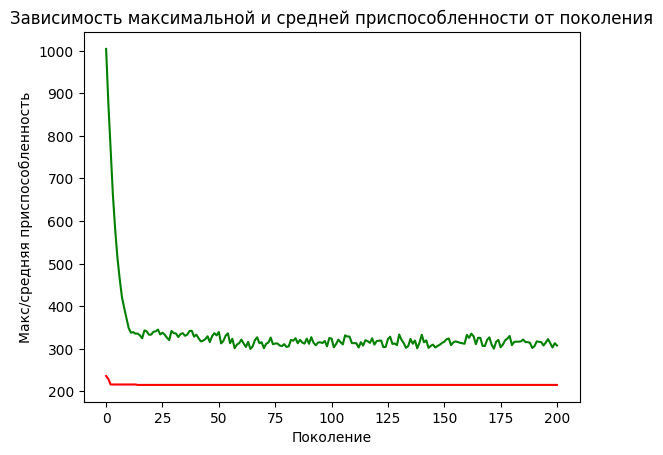

In [902]:
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Поколение')
plt.ylabel('Макс/средняя приспособленность')
plt.title('Зависимость максимальной и средней приспособленности от поколения')
 
plt.show()

In [903]:
best_shedule = hof.items[0]
best_shedule

[0, 10, 11, 0, 0, 0, 0, 10, 4, 0, 0, 17]

In [904]:
for i in range(1, len(best_shedule), 2):
    print(best_shedule[i])

10
0
0
10
0
17


In [905]:
shedule_cost(best_shedule)

(215,)